# Reading 15 million reviews 

*what is the best way to read 15 million reviews?* 

In [3]:
import gzip 
import json
import os

import pandas as pd

In [4]:
DIR = "./data"

In [5]:
def format_data(file_name, head=3_000_000):
    # 15739967
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            print(d)
            count += 1
            
            # only get review_text and review_stars
            data.append([d['review_text'], d['n_votes'], d['rating']])
            # break if reaches the headth line
            if (head is not None) and (count > head):
                break
    return data

In [6]:

# reviews = pd.DataFrame(format_data(os.path.join(
#     DIR, "goodreads_reviews_dedup.json.gz"))
# )

reviews = pd.read_csv("data/sample.csv")
reviews.columns = ["review_text", "n_votes", "rating"]

In [7]:
reviews

,review_text,n_votes,rating
0,Mind blowingly cool. Best science fiction I've...,16,5
1,This is a special book. It started slow for ab...,28,5
2,I haven't read a fun mystery book in a while a...,6,3
3,"Fun, fast paced, and disturbing tale of murder...",22,4
4,A fun book that gives you a sense of living in...,8,4
...,...,...,...
9996,"It still works, but like an 18th century steam...",0,5
9997,Devastating. I was surprised to read that when...,1,5
9998,It was no time to play. It was no time for fun...,2,4
9999,The lesson here is that you cannot know whethe...,1,2


In [8]:
reviews.to_csv(os.path.join(DIR, "sample.csv"), index=False)

Reading 15 million reviews is a challenging task. The reviews are stored in a compressed file, and the file is too large to fit into memory. 

So for now we will read a small subset of the reviews, with the maximum we can extract being 3 million reviews. So an alternate approach is to read the reviews in chunks. 

In this notebook, we will read the reviews in chunks and process them.

# EDA

In [9]:
import nltk

from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import FreqDist

import string

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [10]:
nltk.download('opinion_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/chuks/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/chuks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chuks/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/chuks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Keeping review text as the main focus, but also keeping track of number of votes and ratings, may also be useful. 

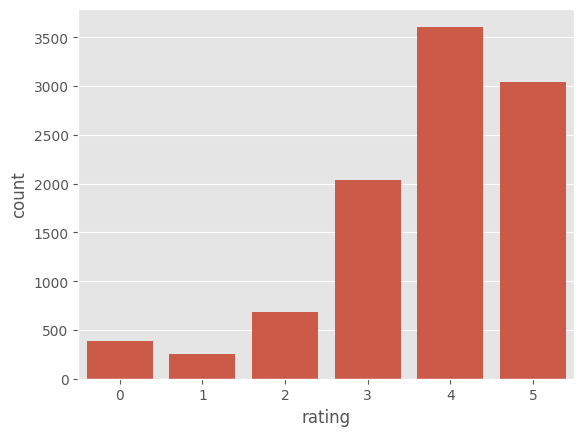

In [11]:
ax = sns.countplot(data=reviews, x='rating')

In [12]:
example = reviews.iloc[55]['review_text']
print(example)

A wonderful, beautifully written, poignant, subtle, and brilliant novel. 
 This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end. It is ultimately a story of regret. It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back. One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework. 
 But what I really loved about the novel is how slow and forcefully it builds. I don't think I've read a book that does that so well since Pride and Prejudice. In the beginning you think it's just a butler going on a motoring trip. And at the end, your heart is breaking. 
 Dignity is a big theme in the novel. Stevens attempts to define dignity several times throughout the novel - his definition generally has to do with self-respect and keeping on

In [13]:
sentences = sent_tokenize(example)

This way we can look at specific tokens within each sentence and see how they are distributed. 

In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
def extract_sentiment_terms(sentence):
    # Tokenize words and tag part of speech
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    sentiment_terms = set()

    for word, tag in tagged_words:
        if word.lower() not in stop_words and word not in string.punctuation:
            if tag.startswith('JJ') or tag.startswith('RB'):
                if word.lower() in opinion_lexicon.positive() or word.lower() in opinion_lexicon.negative():
                    sentiment_terms.add(word)

    return sentiment_terms


In [16]:
sentiment_terms = set()
for sentence in sentences:
    sentiment_terms.update(extract_sentiment_terms(sentence))

Huang, S., Niu, Z., & Shi, C. (2014). Automatic construction of domain-specific sentiment lexicon based on constrained label propagation. Knowledge-Based Systems, 56, 191–200. https://doi.org/10.1016/j.knosys.2013.11.009

Shows that we can extract sentiment terms from tokenised sentences by identifing adjectives (JJ) and adverbs (RB) that are close to the sentiment term.

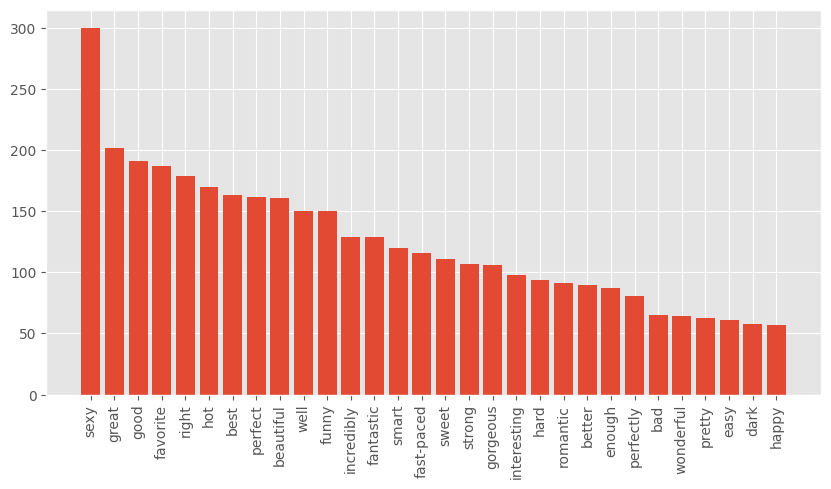

In [17]:
# frequency distribution of words 

processed_reviews = []
for review in reviews['review_text'][:1000]:
    if isinstance(review, str):  # Check if review is a string
        processed_reviews.extend(extract_sentiment_terms(review))

freq_dist = FreqDist(processed_reviews)

# Get the 30 most common words
common_words = freq_dist.most_common(30)

# Unzip the list of tuples into two lists
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation='vertical')
plt.show()

when looking at the distribution of the sentiment terms, we can see that the sentiment, as we can see words with positive sentiment are more common than negative sentiment words, and this also corralates with the ratings of the reviews.

In [18]:
sentiment_terms = list(sentiment_terms)
sentiment_terms

['slow',
 'brilliant',
 'Good',
 'better',
 'favorite',
 'interesting',
 'great',
 'wonderful',
 'well',
 'best',
 'beautifully',
 'self-respect',
 'hard',
 'fond',
 'poignant']

From each sentence we have extracted the sentiment terms, from each sentence and now is in the form of a list. 

Now we can apply this function to all the reviews in our dataset.

In [19]:
from gensim.models import Word2Vec

In [20]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

In [21]:
def learn_word_embeddings(processed_corpus):
    # Train a Word2Vec model on the processed corpus
    model = Word2Vec(sentences=processed_corpus,
                     vector_size=100, window=5, min_count=1, workers=4)
    return model       

In [22]:
model = learn_word_embeddings([word_tokenize(word) for word in sentences])

for token in sentiment_terms:
    if token in model.wv:
        print(f"{token}: {model.wv.most_similar(token)}")
    else:
        synonyms = get_synonyms(token)

        for synonym in synonyms:
            if synonym in model.wv:
                print(f"{synonym}: {model.wv.most_similar(synonym)}")

slow: [('poignant', 0.27079635858535767), ('done', 0.25222718715667725), ('interesting', 0.23129600286483765), ('few', 0.23062986135482788), ('suppression', 0.2157343178987503), ('great', 0.20311890542507172), ('across', 0.20079772174358368), ('why', 0.1949823647737503), ('tiger', 0.18664713203907013), ('value', 0.18180930614471436)]
brilliant: [('beginning', 0.2660817503929138), ('tell', 0.23735637962818146), ('whose', 0.2309322953224182), ('beautifully', 0.2159026861190796), ('things', 0.19439125061035156), ('from', 0.1893511265516281), ('issue', 0.18053656816482544), (':', 0.17972107231616974), ('keeping', 0.17918911576271057), ('Minimization', 0.16778625547885895)]
Good: [("'But", 0.2631402015686035), ('understand', 0.2548622786998749), ('quotes', 0.2241232544183731), ('It', 0.2123100906610489), ('bunch', 0.20617054402828217), ('Prejudice', 0.18927255272865295), ('since', 0.1841874122619629), ('him', 0.18416845798492432), ('check', 0.18289338052272797), ('himself', 0.18114103376865

By tokenising each word in the sentence we can also find similar word pairs that are close to the sentiment term. Using `get_synonyms` we can find similar words to the sentiment term using the WordNet corpus.

This can be expanded upon by providing a larger dataset to train on.

#### Approach

1. Read the reviews in chunks
2. Tokenize the reviews and process sentences
3. Extract sentiment terms
4. Extract similar word pairs
5. Train a model on the processesd_corpus



# Trait Dataset

In [23]:
essays = pd.read_csv('data/essays.csv')

## Preprocessing

In [24]:
essays = essays.rename(columns={
    'TEXT': 'text',
    'cEXT': 'extroversion',
    'cNEU': 'neuroticism',
    'cAGR': 'agreeableness',
    'cCON': 'conscientiousness',
    'cOPN': 'openness'
})

# subset the data text + big five

essays = essays[['text', 'extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']]

# convert n and y to 0 and 1
essays = essays.replace({'n': 0, 'y': 1})

/tmp/ipykernel_21565/1694335583.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  essays = essays.replace({'n': 0, 'y': 1})


In [25]:
essays

,text,extroversion,neuroticism,agreeableness,conscientiousness,openness
0,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,I can't believe it! It's really happening! M...,1,0,1,1,0
4,"Well, here I go with the good old stream of co...",1,0,1,0,1
...,...,...,...,...,...,...
2462,I'm home. wanted to go to bed but remembe...,0,1,0,1,0
2463,Stream of consiousnesssskdj. How do you s...,1,1,0,0,1
2464,"It is Wednesday, December 8th and a lot has be...",0,0,1,0,0
2465,"Man this week has been hellish. Anyways, now i...",0,1,0,0,1


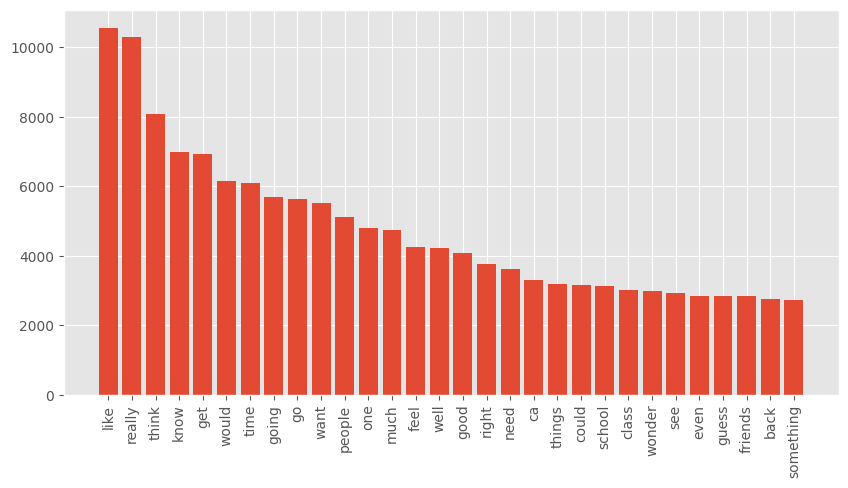

In [26]:
processed_essays = []
for essay in essays['text']:
    words = word_tokenize(essay)
    processed_essays.extend([word.lower() for word in words if word.isalpha() and word.lower() not in stop_words])

freq_dist = FreqDist(processed_essays)

# Get the 30 most common words
common_words = freq_dist.most_common(30)

# Unzip the list of tuples into two lists
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation='vertical')
plt.show()

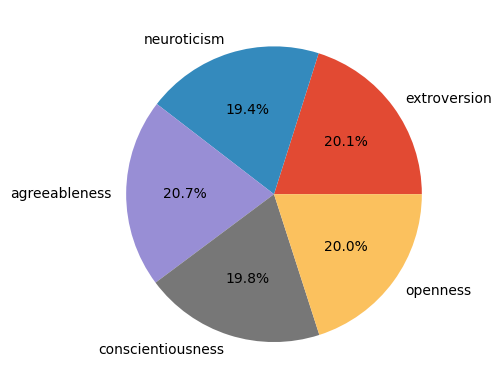

In [27]:
categories = ['extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']

counts = [essays[category].sum() for category in categories]

plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.show()

All traits represent around 20% of the total dataset. The traits are extracted from the reviews and are used to train the model.

In [28]:
essays.to_pickle('data/essays-preprocessed.pkl')

In [29]:
traits = ['extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']

## Training the model

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from preprocessing import preprocess_text
from tqdm import tqdm
import pandas as pd
import joblib

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/chuks/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/chuks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chuks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chuks/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [31]:
tqdm.pandas()

def load_data(file_path):
    # Load Pickled data
    df = pd.read_pickle(file_path)

    # preprocess_text returns preprocessed text, sentiment terms split this into two columns
    df['processed_text'], df['sentiment_terms'] = zip(
        *df['text'].progress_apply(preprocess_text))

    return df

In [32]:
def evaluate_model(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1

In [33]:
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC={auc:.2f})')
    plt.show()

In [34]:
from sklearn.preprocessing import LabelBinarizer

def plot_multi_roc_curve(y_test, y_pred_proba, class_labels=None):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    n_classes = y_test.shape[1]


    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], y_pred_proba[:, i])

    plt.figure()

    for i in range(n_classes):
        if class_labels:
            plt.plot(fpr[i], tpr[i],
            label=f'{class_labels[i]} (area = {roc_auc[i]:.2f})')
        else:
            plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [35]:
def train_model(df, target_columns, pipeline, model_path, multi_class=False, traits=None):
    y = df[target_columns]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42)

    # Train the model
    model = pipeline.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model.predict(X_test)
    # proba
    y_pred_proba = model.predict_proba(X_test)

    # Evaluate the model
    accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)
    
    # Save the model
    if model_path is not None:
        joblib.dump(model, model_path)

    # Create a dataframe to store the results
    results = pd.DataFrame({
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1]
    })

    if multi_class:
        roc = plot_multi_roc_curve(y_test, y_pred_proba, traits)
    else:
        roc = plot_roc_curve(y_test, y_pred_proba[:, 1])

    return model, results, roc

In [36]:
def predict_sentence(model, sentence):
    result = preprocess_text(sentence)
    if result is None:
        return None, None

    processed_text, sentiment_terms = result
    processed_text = ' '.join(map(str, processed_text)) if processed_text else ""
    sentiment_terms = ' '.join(map(str, sentiment_terms)) if sentiment_terms else ""

    # Create a DataFrame that matches the input your model expects
    df = pd.DataFrame({
        'processed_text': [processed_text],
        'sentiment_terms': [sentiment_terms]
    })

    # Use the model to predict the class of the sentence
    prediction = model.predict(df)
    pred_proba = model.predict_proba(df)

    return prediction, pred_proba

In [37]:
from numpy import concatenate


def predict_and_concatenate(models, test_sentence):
    predictions = []
    prediction_probabilities = []
    for model in models:
        
        result = preprocess_text(sentence)
        if result is None:
            return None, None

        processed_text, sentiment_terms = result
        processed_text = ' '.join(map(str, processed_text)) if processed_text else ""
        sentiment_terms = ' '.join(map(str, sentiment_terms)) if sentiment_terms else ""

        df = pd.DataFrame({
            'processed_text': [processed_text],
            'sentiment_terms': [sentiment_terms]
        })

        # Predicting with each model
        pred = model[1].predict(df)
        pred_proba = model[1].predict_proba(df)
        
        # Assuming binary classification, ensuring binary output (0 or 1)
        predictions.append(pred)
        prediction_probabilities.append(pred_proba)
    
    # Transposing to get predictions for each sample across all models
    predictions_per_sample = list(zip(*predictions))
    predictions_per_sample_proba = list(zip(*prediction_probabilities))

    # Concatenating binary predictions for each sample into a single string
    concatenated_predictions = [''.join(map(str, sample_preds)) for sample_preds in predictions_per_sample]

    concatenated_prediction_probabilities = [list(map(lambda x: x[1], sample_preds)) for sample_preds in predictions_per_sample_proba]

    return concatenated_predictions, concatenated_prediction_probabilities

In [38]:
# df = load_data('data/essays.pkl')

In [39]:
# df.to_pickle('data/essays-preprocessed.pkl')

In [40]:
# df.to_csv('data/essays-preprocessed.csv', index=False)

In [41]:
df = pd.read_csv('data/essays-preprocessed.csv')

In [42]:
df.columns

Index(['text', 'extroversion', 'neuroticism', 'agreeableness',
       'conscientiousness', 'openness', 'processed_text', 'sentiment_terms'],
      dtype='object')

In [43]:
df["sentiment_terms"]

0       {'right', 'difficult', 'nagging', 'enough', 'h...
1       {'pretty', 'right', 'lack', 'nice', 'interesti...
2       {'happy', 'wallow', 'incorrect', 'unknown', 'a...
3       {'great', 'right', 'excited', 'like', 'perfect...
4       {'mysterious', 'sorry', 'ridiculous', 'unfortu...
                              ...                        
2462                    {'right', 'wow', 'noise', 'fine'}
2463    {'warmth', 'ridiculous', 'hot', 'better', 'dam...
2464    {'pretty', 'right', 'unthinkable', 'enough', '...
2465    {'best', 'cool', 'exhausted', 'miss', 'fake', ...
2466    {'best', 'crazy', 'glad', 'lie', 'better', 'ne...
Name: sentiment_terms, Length: 2467, dtype: object

In [44]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

Naive Bayes is used to train the model. The model is trained on the traits and the sentiment terms extracted from the reviews.

In [45]:
from sklearn.naive_bayes import MultinomialNB

In [46]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [47]:
pipe = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('text', Pipeline([
                ('selector', ItemSelector(key='processed_text')),
                ('tfidf', TfidfVectorizer()),
            ])),
            ('sentiment', Pipeline([
                ('selector', ItemSelector(key='sentiment_terms')),
                ('tfidf', TfidfVectorizer()),
            ])),
        ],
    )),
    ('clf', OneVsRestClassifier(MultinomialNB())),
])

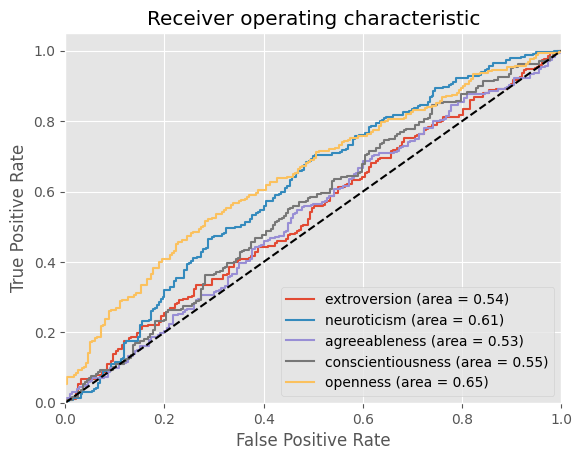

(   accuracy  precision    recall        f1
 0   0.05668   0.566634  0.801386  0.655553,
 None)

In [48]:
nb_model, results, roc = train_model(df, traits, pipe, None, multi_class=True, traits=traits)
results, roc

In [49]:
predict_sentence(nb_model, "Angry")

(array([[0, 1, 0, 0, 0]]),
 array([[0.45033396, 0.53066729, 0.45247378, 0.46625228, 0.47649457]]))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5; 1/4] START clf__estimator__alpha=0.01, clf__estimator__fit_prior=True..
[CV 1/5; 1/4] START clf__estimator__alpha=0.01, clf__estimator__fit_prior=True..
[CV 2/5; 1/4] START clf__estimator__alpha=0.01, clf__estimator__fit_prior=True..
[CV 4/5; 1/4] START clf__estimator__alpha=0.01, clf__estimator__fit_prior=True..
[CV 1/5; 1/4] END clf__estimator__alpha=0.01, clf__estimator__fit_prior=True;, score=0.076 total time=   0.5s
[CV 3/5; 1/4] END clf__estimator__alpha=0.01, clf__estimator__fit_prior=True;, score=0.043 total time=   0.5s
[CV 2/5; 2/4] START clf__estimator__alpha=0.01, clf__estimator__fit_prior=False.
[CV 3/5; 2/4] START clf__estimator__alpha=0.01, clf__estimator__fit_prior=False.
[CV 4/5; 1/4] END clf__estimator__alpha=0.01, clf__estimator__fit_prior=True;, score=0.066 total time=   0.6s
[CV 5/5; 1/4] START clf__estimator__alpha=0.01, clf__estimator__fit_prior=True..
[CV 4/5; 2/4] START clf__estimator__alpha=0

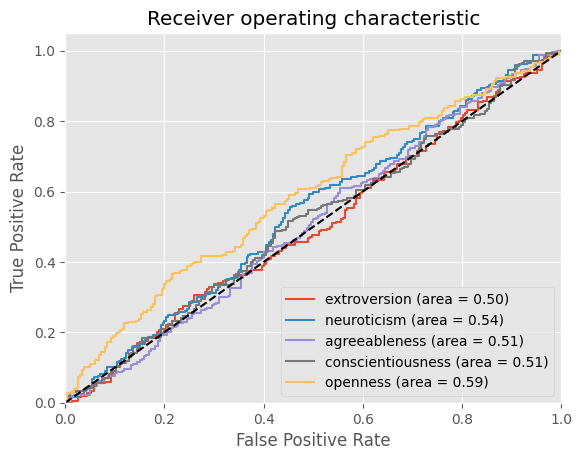

(   accuracy  precision    recall        f1
 0  0.052632   0.549826  0.581986  0.565376,
 None)

In [50]:
parameters = {
    'clf__estimator__alpha': (1e-2, 1e-3),
    'clf__estimator__fit_prior': (True, False),
}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=10)

nb_model, results, roc = train_model(df, traits, grid_search, None, multi_class=True, traits=traits)

results, roc

In [51]:
predict_sentence(nb_model, "Angry")

(array([[0, 1, 0, 0, 0]]),
 array([[0.40467788, 0.52609724, 0.38083056, 0.45384728, 0.4317862 ]]))

In [52]:
pipe.set_params(clf=MultinomialNB(alpha=0.1))


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='processed_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('sentiment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='sentiment_terms')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('clf', MultinomialNB(alpha=0.1))])

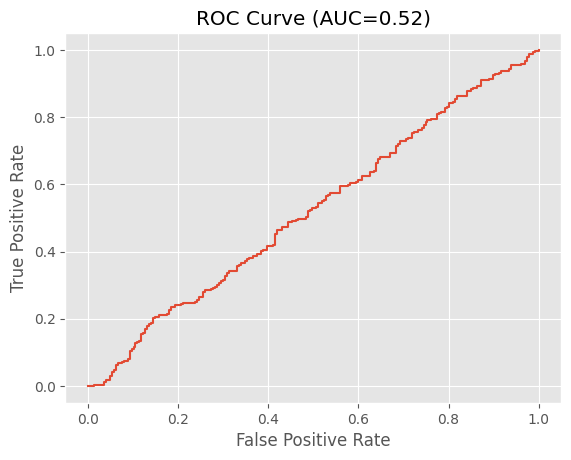

Training model for extroversion
   accuracy  precision    recall        f1
0  0.522267   0.514146  0.522267  0.511957
None


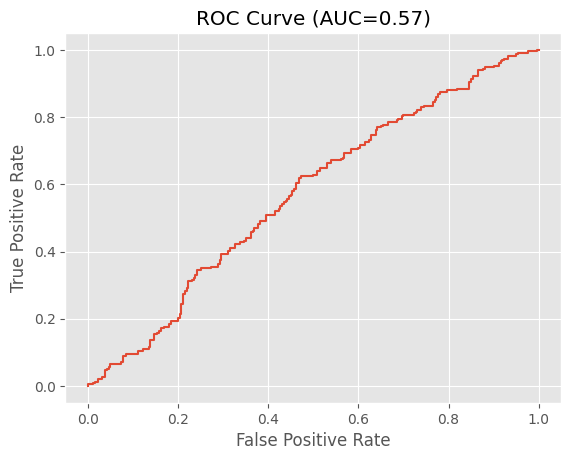

Training model for neuroticism
   accuracy  precision    recall        f1
0  0.560729   0.566682  0.560729  0.559411
None


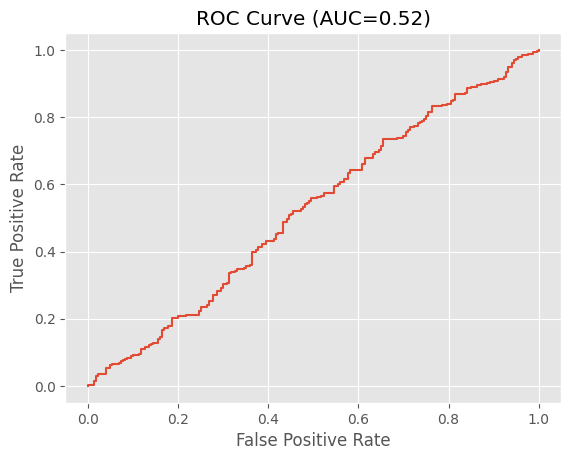

Training model for agreeableness
   accuracy  precision    recall        f1
0  0.554656   0.543034  0.554656  0.536126
None


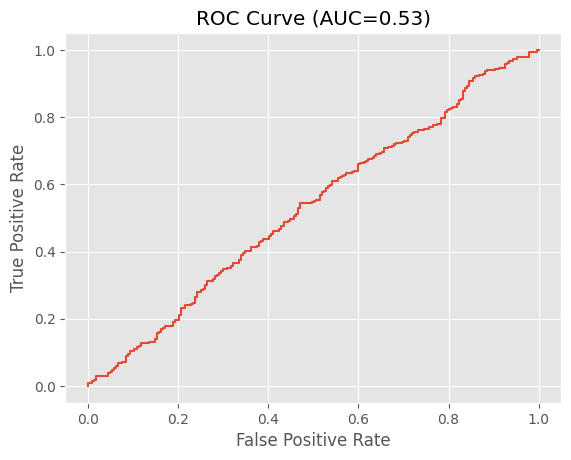

Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.536437   0.529682  0.536437  0.527312
None


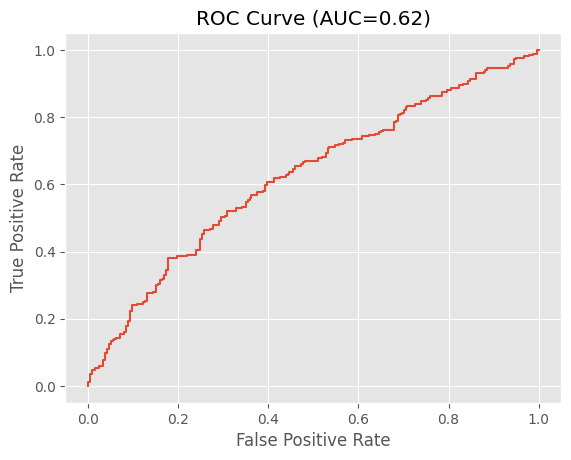

Training model for openness
   accuracy  precision    recall        f1
0  0.593117   0.598502  0.593117  0.591679
None


In [53]:
nb_models = []
nb_metrics = []

for t in traits:
    model, metrics, roc = train_model(df, t, pipe, None)
    print(f'Training model for {t}')
    print(metrics)
    print(roc)
    nb_models.append((t, model))
    nb_metrics.append((t, metrics))

In [54]:
predict_and_concatenate(nb_models, "Love")

(['00000'],
 [[0.3920957526222628,
   0.3920957526222628,
   0.3920957526222628,
   0.3920957526222628,
   0.3920957526222628]])

### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
pipe.set_params(clf=OneVsRestClassifier(LogisticRegression(multi_class='auto', )))

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='processed_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('sentiment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='sentiment_terms')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

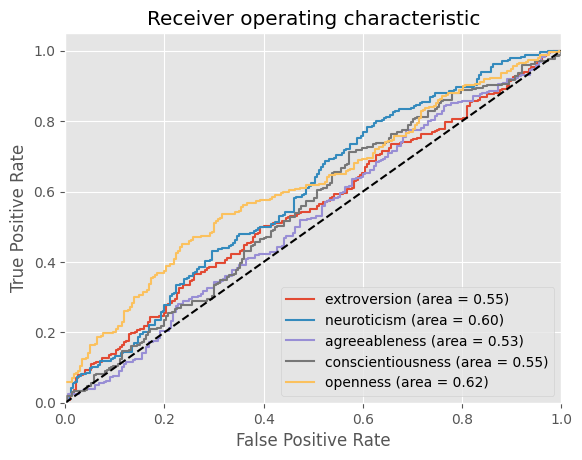

(   accuracy  precision    recall        f1
 0  0.038462    0.57122  0.590454  0.580174,
 None)

In [57]:
lr_model, results, roc = train_model(df, traits, pipe, None, multi_class=True, traits=traits)

results, roc

In [58]:
predict_sentence(lr_model, 'You')

(array([[0, 0, 0, 0, 1]]),
 array([[0.44149996, 0.45491907, 0.40114439, 0.32853177, 0.66144922]]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__estimator__C=1, clf__estimator__penalty=l1.............
[CV 2/5; 1/6] START clf__estimator__C=1, clf__estimator__penalty=l1.............
[CV 3/5; 1/6] START clf__estimator__C=1, clf__estimator__penalty=l1.............
[CV 4/5; 1/6] START clf__estimator__C=1, clf__estimator__penalty=l1.............
[CV 1/5; 2/6] START clf__estimator__C=1, clf__estimator__penalty=l2.............
[CV 5/5; 1/6] START clf__estimator__C=1, clf__estimator__penalty=l1.............
[CV 1/5; 1/6] END clf__estimator__C=1, clf__estimator__penalty=l1;, score=nan total time=   0.5s[CV 2/5; 1/6] END clf__estimator__C=1, clf__estimator__penalty=l1;, score=nan total time=   0.5s

[CV 3/5; 1/6] END clf__estimator__C=1, clf__estimator__penalty=l1;, score=nan total time=   0.5s
[CV 2/5; 2/6] START clf__estimator__C=1, clf__estimator__penalty=l2.............
[CV 3/5; 2/6] START clf__estimator__C=1, clf__estimator__penalty=l2.............
[

/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 475, in fit
    s

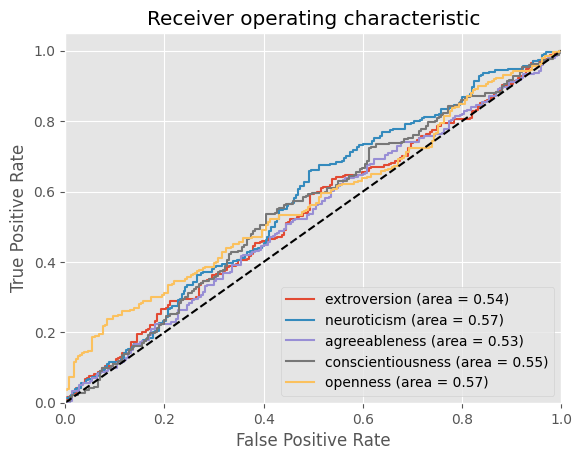

(   accuracy  precision   recall        f1
 0  0.054656   0.565056  0.56428  0.564125,
 None)

In [59]:
parameters = {
    'clf__estimator__C': (1, 10, 100),
    'clf__estimator__penalty': ('l1', 'l2'),
}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=10)

lr_model, results, roc = train_model(df, traits, grid_search, None, multi_class=True, traits=traits)

results, roc

In [60]:
predict_sentence(grid_search, 'You')

(array([[0, 0, 0, 0, 1]]),
 array([[0.36200186, 0.26624906, 0.33185408, 0.08776449, 0.82490671]]))

#### Multi Model Approach

In [61]:
pipe.set_params(clf=OneVsRestClassifier(LogisticRegression()))

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='processed_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('sentiment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='sentiment_terms')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

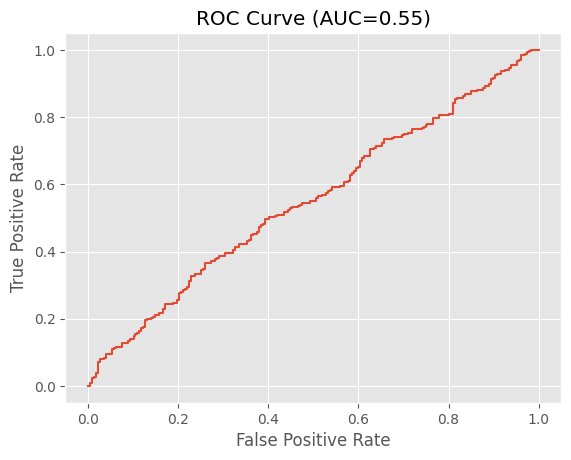

Training model for extroversion
   accuracy  precision   recall        f1
0   0.52834   0.527876  0.52834  0.528089
None


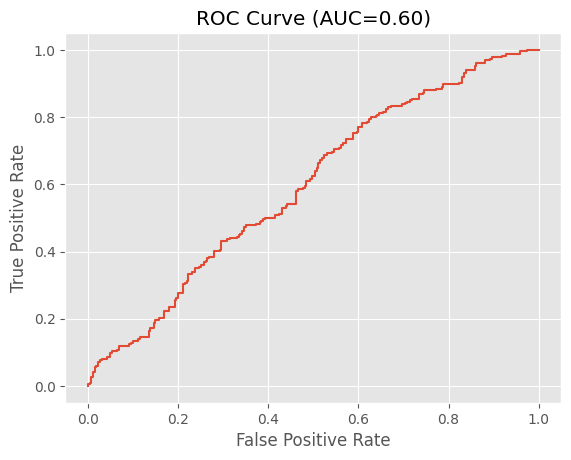

Training model for neuroticism
   accuracy  precision   recall       f1
0   0.55668   0.560836  0.55668  0.55626
None


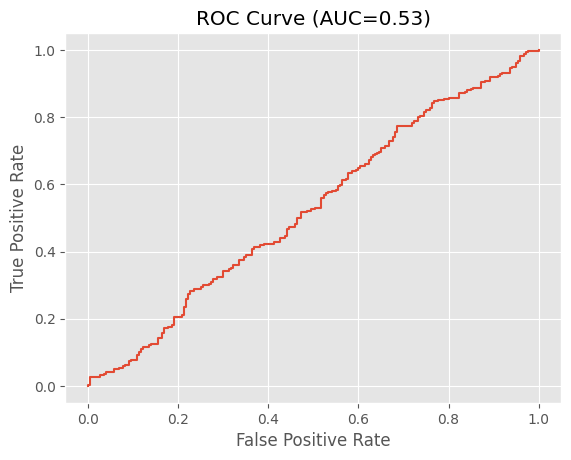

Training model for agreeableness
   accuracy  precision   recall        f1
0   0.52834   0.525634  0.52834  0.526625
None


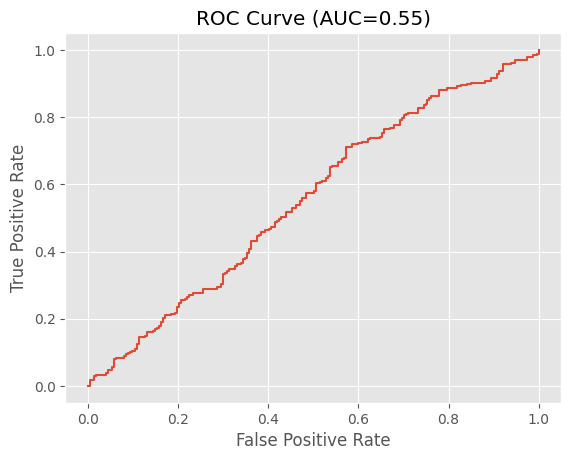

Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.550607   0.548931  0.550607  0.549445
None


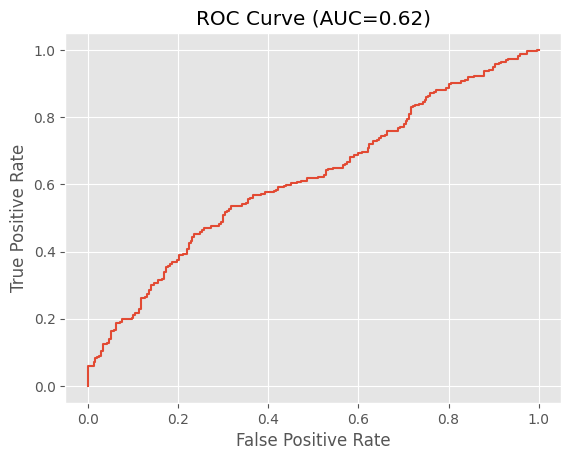

Training model for openness
   accuracy  precision    recall        f1
0  0.587045   0.588272  0.587045  0.587187
None


In [62]:
lr_models = []
lr_metrics = []

for t in traits:
    model, metrics, roc = train_model(df, t, pipe, None)
    print(f'Training model for {t}') 
    print(metrics) 
    print(roc)
    lr_models.append((t, model))
    lr_metrics.append((t, metrics)) 

In [63]:
predict_and_concatenate(lr_models, 'I am a very happy person')

(['11111'],
 [[0.6175805054073203,
   0.6175805054073203,
   0.6175805054073203,
   0.6175805054073203,
   0.6175805054073203]])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


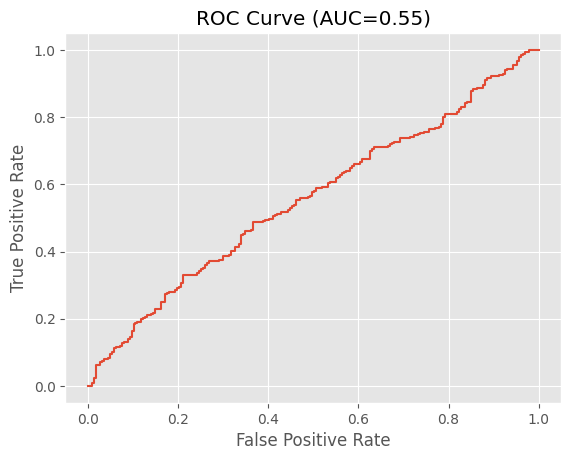

Training model for extroversion
   accuracy  precision    recall        f1
0  0.540486   0.540036  0.540486  0.540241
None
Fitting 5 folds for each of 27 candidates, totalling 135 fits


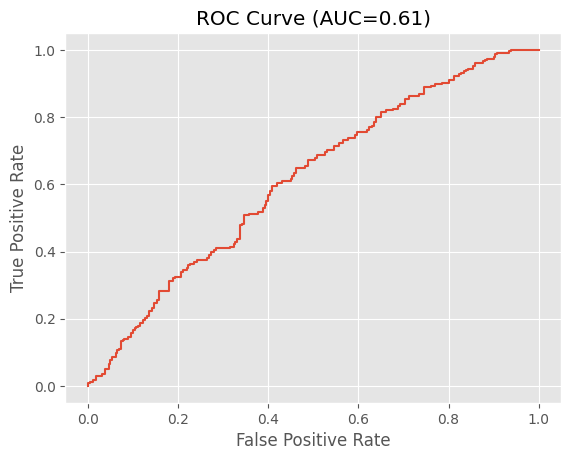

Training model for neuroticism
   accuracy  precision    recall        f1
0  0.582996   0.591507  0.582996  0.580679
None
Fitting 5 folds for each of 27 candidates, totalling 135 fits


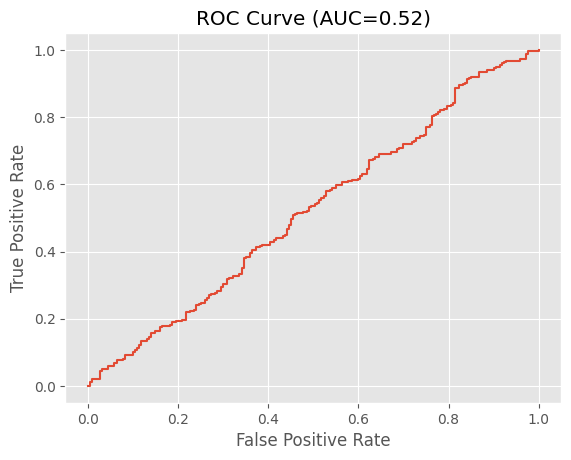

Training model for agreeableness
   accuracy  precision    recall        f1
0  0.546559   0.527676  0.546559  0.507616
None
Fitting 5 folds for each of 27 candidates, totalling 135 fits


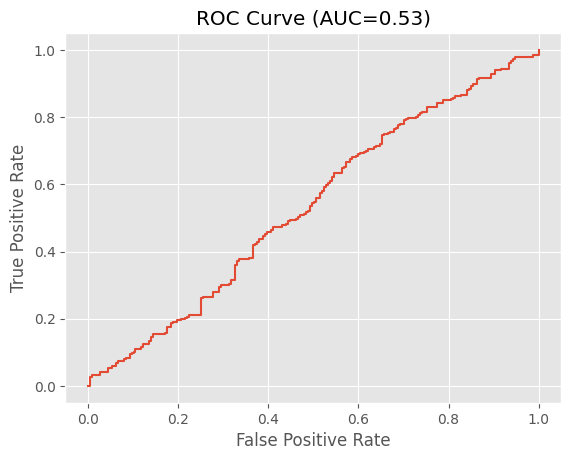

Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.526316    0.52663  0.526316  0.526464
None
Fitting 5 folds for each of 27 candidates, totalling 135 fits


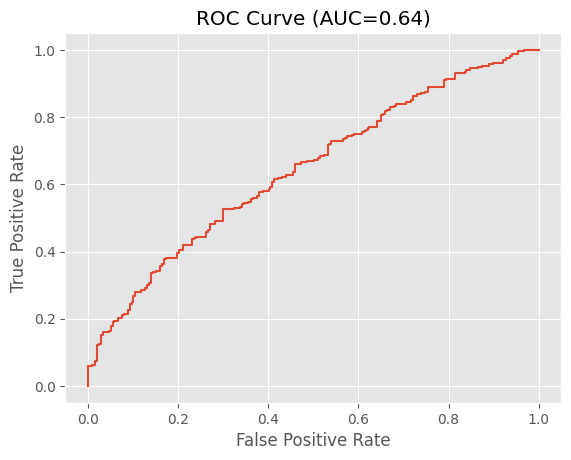

Training model for openness
   accuracy  precision    recall        f1
0  0.589069   0.588416  0.589069  0.586089
None


In [65]:
parameters = {
    'union__text__tfidf__max_df': (0.25, 0.5, 0.75),
    'union__text__tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__C': [0.1, 1, 10]  # Corrected parameter
}

# Update the model in GridSearchCV to the pipeline model
grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=1)

for t in traits:
    model, metrics, roc = train_model(df, t, grid_search, None)
    print(f'Training model for {t}') 
    print(metrics) 
    print(roc)
    lr_models.append((t, model))
    lr_metrics.append((t, metrics))  

### SVM

In [76]:
from sklearn.svm import SVC

In [77]:
pipe.set_params(clf=OneVsRestClassifier(SVC(kernel='linear',probability=True)))

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='processed_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('sentiment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='sentiment_terms')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('clf',
                 OneVsRestClassifier(estimator=SVC(kernel='linear',
                                                   probability=True)))])

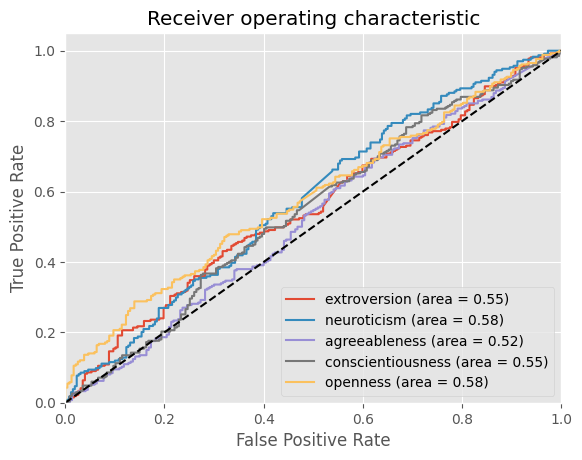

(   accuracy  precision    recall        f1
 0  0.040486   0.560245  0.568129  0.563736,
 None)

In [79]:
svm_model, results, roc = train_model(df, traits, pipe, None, multi_class=True, traits=traits)
results, roc

In [84]:
predict_sentence(svm_model, 'Love')

(array([[1, 0, 0, 0, 1]]),
 array([[0.64762138, 0.5       , 0.51569329, 0.41409329, 0.75094172]]))

Using OneVsRestClassifier is a simple way to train a multi-label classification model.

But its performance is not good enough. with accuracy of 0.07. 

In [85]:
pipe.set_params(clf=SVC(kernel='linear', probability=True))

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='processed_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('sentiment',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='sentiment_terms')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('clf', SVC(kernel='linear', probability=True))])

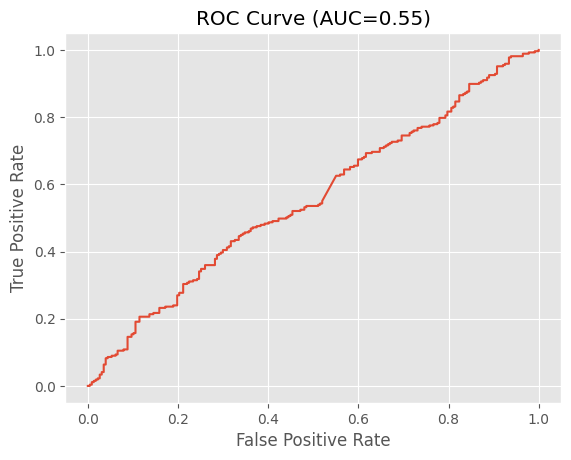

Training model for extroversion
   accuracy  precision    recall        f1
0  0.516194   0.517321  0.516194  0.516654
None


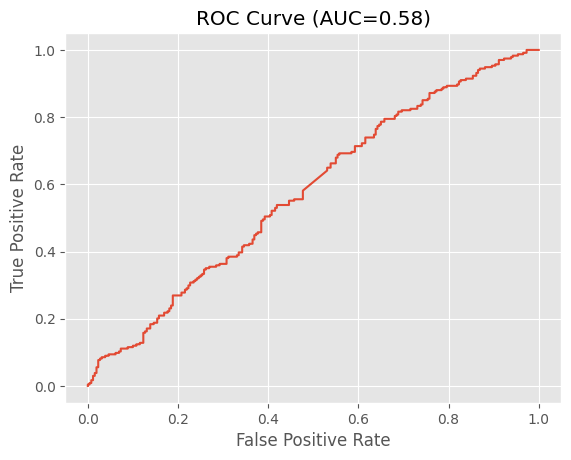

Training model for neuroticism
   accuracy  precision    recall        f1
0  0.550607   0.553951  0.550607  0.550504
None


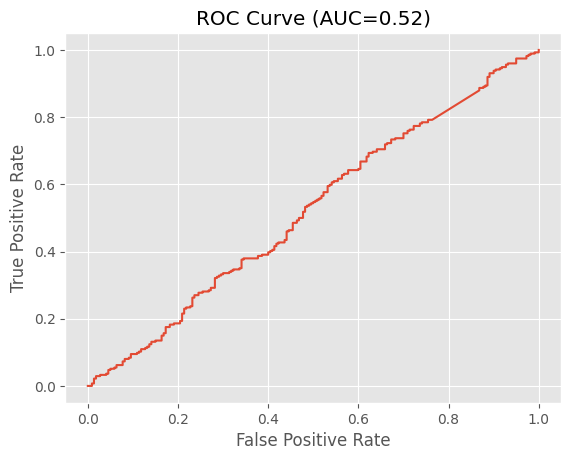

Training model for agreeableness
   accuracy  precision   recall        f1
0   0.52834   0.529404  0.52834  0.528818
None


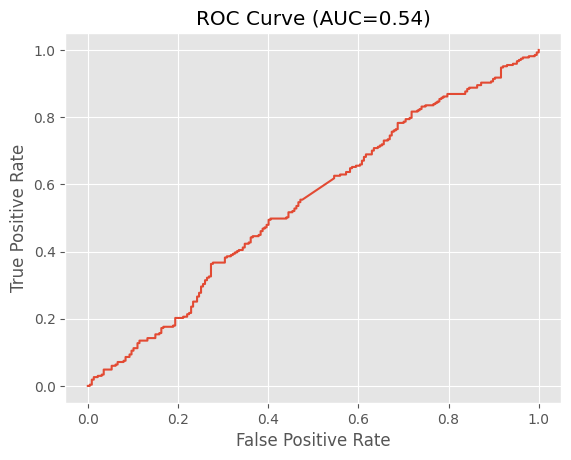

Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.544534   0.542684  0.544534  0.543233
None


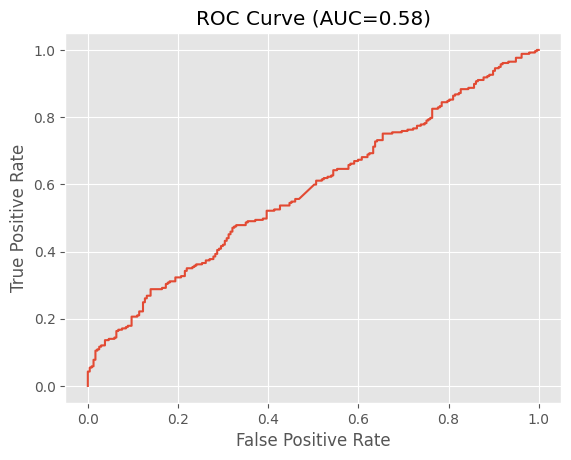

Training model for openness
   accuracy  precision    recall        f1
0  0.548583   0.549313  0.548583  0.548766
None


In [86]:
svm_models = []
svm_metrics = []

for t in traits:
    model, metrics, roc = train_model(df, t, pipe, None)
    print(f'Training model for {t}') 
    print(metrics)
    print(roc) 
    svm_models.append((t, model))
    svm_metrics.append((t, metrics))


In [91]:
parameters = {
    'union__text__tfidf__max_df': (0.25, 0.5, 0.75),
    'union__text__tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__coef0': (0.1, 1, 10),
}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=0)

svm_models = []
svm_metrics = []

for t in traits:
    model, metrics, roc = train_model(df, t, grid_search, None)
    print(f'Training model for {t}') 
    print(metrics) 
    print(roc)
    svm_models.append((t, model))
    svm_metrics.append((t, metrics))

In [ ]:
predict_and_concatenate(svm_models, 'I am a very happy person')

['11111']

### Random Forest Classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipe.set_params(clf=RandomForestClassifier())

In [ ]:
rf_models = []
rf_metrics = []

for t in traits:
    model, metrics, roc = train_model(df, t, pipe, None)
    print(f'Training model for {t}') 
    print(metrics)
    print(roc)
    rf_models.append((t, model))
    rf_metrics.append((t, metrics))

Training model for extroversion
   accuracy  precision   recall        f1
0   0.54251   0.538001  0.54251  0.537685
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.566802   0.568819  0.566802  0.567057
Training model for agreeableness
   accuracy  precision    recall        f1
0  0.544534   0.532245  0.544534  0.527647
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.534413   0.535998  0.534413  0.534987
Training model for openness
   accuracy  precision    recall        f1
0  0.552632   0.556292  0.552632  0.551668


In [ ]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=10)

rf_models = []
rf_metrics = []

for t in traits:
    model, metrics, roc = train_model(df, t, grid_search, None)
    print(f'Training model for {t}') 
    print(metrics) 
    print(roc)
    rf_models.append((t, model))
    rf_metrics.append((t, metrics))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for extroversion
   accuracy  precision    recall        f1
0  0.544534   0.536855  0.544534  0.530496
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.520243   0.527688  0.520243  0.516398
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for agreeableness
   accuracy  precision    recall        f1
0  0.530364   0.508334  0.530364  0.496351
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.548583   0.549346  0.548583  0.548908
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for openness
   accuracy  precision    recall        f1
0  0.605263   0.606863  0.605263  0.605346


In [ ]:
predict_and_concatenate(rf_models, 'I am a very happy person')

['11111']

## BERT Model 

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

x = pd.DataFrame({
    'processed_text': df["processed_text"],
    'sentiment_terms': df["sentiment_terms"]
})

# Split data into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(x, df[traits], test_size=0.2, random_state=42)


/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

In [ ]:
class PersonalityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PersonalityDataset(train_encodings, train_labels)
val_dataset = PersonalityDataset(val_encodings, val_labels)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df[traits].columns))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.737500
20,0.713500
30,0.698000
40,0.685500
50,0.704200
60,0.695100
70,0.695200
80,0.693600
90,0.701900
100,0.697300


TrainOutput(global_step=1235, training_loss=0.6971163213011707, metrics={'train_runtime': 648.3463, 'train_samples_per_second': 15.216, 'train_steps_per_second': 1.905, 'total_flos': 2595660475407360.0, 'train_loss': 0.6971163213011707, 'epoch': 5.0})

In [ ]:
trainer.evaluate() 

{'eval_loss': 0.6919950842857361,
 'eval_runtime': 9.1759,
 'eval_samples_per_second': 53.836,
 'eval_steps_per_second': 3.378,
 'epoch': 5.0}

In [ ]:
def predict_bert(model, test_sentence):
    result = preprocess_text(test_sentence)
    if result == None:
        result = ''
        
    processed_text, sentiment_terms = result
    processed_text = ' '.join(map(str, processed_text))
    sentiment_terms = ' '.join(map(str, sentiment_terms))

    df = pd.DataFrame({
        'processed_text': [processed_text],
        'sentiment_terms': [sentiment_terms]
    })


    test_encodings = tokenizer(df, truncation=True, padding=True, max_length=512)
    test_dataset = PersonalityDataset(test_encodings, pd.DataFrame([0, 0, 0, 0, 0]))
    predictions = model.predict(test_dataset)
    pred_proba = model.predict_proba(test_dataset)
    return predictions, pred_proba

predict_bert(trainer, 'I am a very happy person')

(['happy', 'person'], {'happy'})
['happy', 'person'] {'happy'}


ValueError: not enough values to unpack (expected 2, got 1)

# LIWC classification

In [ ]:
import liwc

parse, category_name = liwc.load_token_parser('data/LIWC2007_English100131.dic')

In [ ]:
# LIWC 2007
from nltk.tokenize import word_tokenize

sentences = '''i care about you abdomen'''
tokens = word_tokenize(sentences.lower())

# List of lists of categories for each token
matches = {token : [category for category in parse(token)] for token in tokens}
matches

{'i': ['funct', 'pronoun', 'ppron', 'i'],
 'care': ['verb', 'present', 'affect', 'posemo'],
 'about': ['funct', 'adverb', 'preps'],
 'you': ['funct', 'pronoun', 'ppron', 'you', 'social'],
 'abdomen': ['bio', 'body']}

Words that do not appear in the LIWC dictionary are not identified. 

The LIWC dictionary is not perfect, but it is a good starting point, and it is easy to use.

One Solution is to use the LIWC dictionary to identify the words that are not in the dictionary, and then use a different method to identify the words that are not in the dictionary, such as another classification model. 

In [ ]:
# parse every word in LIWC2007_English100131.dic
from liwc import read_dic
from collections import defaultdict

lexicon, category_names = read_dic('data/LIWC2007_English100131.dic')

len(lexicon)

4484

In [ ]:
# create a dataframe to store the lexicon (word, category)

liwc_lexicon = defaultdict(list)
for word, categories in lexicon.items():
    liwc_lexicon['word'].append(word_tokenize(word)[0])
    liwc_lexicon['categories'].append(categories)

liwc_lexicon = pd.DataFrame(liwc_lexicon)

liwc_lexicon.head()
liwc_lexicon.to_csv('data/liwc_lexicon.csv', index=False)

In [ ]:
liwc_lexicon = defaultdict(list)
for word, categories in lexicon.items():
    liwc_lexicon['preprocessed_text'].append(word_tokenize(word)[0])
    for category in category_names:
        liwc_lexicon[category].append(int(category in categories))

liwc_lexicon = pd.DataFrame(liwc_lexicon)

liwc_lexicon.head()

,preprocessed_text,funct,pronoun,ppron,i,we,you,shehe,they,ipron,...,work,achieve,leisure,home,money,relig,death,assent,nonfl,filler
0,a,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abandon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abdomen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abilit,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,able,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
liwc_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(dual=True))
])

In [ ]:
liwc_models = []
liwc_metrics = []

for i in category_names:
    model, metrics = train_model(liwc_lexicon, i, liwc_model, None)
    print(f'Training model for {i}')
    print(metrics)
    liwc_models.append((i, model))
    liwc_metrics.append((i, metrics))

Training model for funct
   accuracy  precision    recall       f1
0  0.911929   0.915271  0.911929  0.88497
Training model for pronoun
   accuracy  precision    recall        f1
0  0.982163   0.980692  0.982163  0.978332
Training model for ppron
   accuracy  precision    recall       f1
0  0.989967   0.989061  0.989967  0.98846
Training model for i
   accuracy  precision   recall        f1
0   0.99777   0.995546  0.99777  0.996657
Training model for we
   accuracy  precision   recall        f1
0   0.99777   0.997775  0.99777  0.997214
Training model for you
   accuracy  precision    recall        f1
0  0.998885   0.998886  0.998885  0.998774
Training model for shehe
   accuracy  precision    recall        f1
0  0.998885   0.998886  0.998885  0.998774


/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training model for they
   accuracy  precision    recall        f1
0  0.996656   0.996286  0.996656  0.996418
Training model for ipron
   accuracy  precision    recall        f1
0  0.992196   0.992257  0.992196  0.989177
Training model for article
   accuracy  precision    recall        f1
0  0.998885   0.997772  0.998885  0.998328
Training model for verb
   accuracy  precision    recall        f1
0  0.925307   0.921709  0.925307  0.901925
Training model for auxverb
   accuracy  precision    recall        f1
0  0.972129   0.967527  0.972129  0.967224
Training model for past
   accuracy  precision    recall        f1
0  0.972129   0.972909  0.972129  0.961089
Training model for present
   accuracy  precision    recall        f1
0  0.963211   0.952928  0.963211  0.948124
Training model for future
   accuracy  precision    recall       f1
0  0.986622   0.986801  0.986622  0.98165
Training model for adverb
   accuracy  precision    recall        f1
0  0.981048   0.962455  0.981048  0.97166

/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/li

Training model for preps
   accuracy  precision    recall        f1
0  0.985507   0.971225  0.985507  0.978314
Training model for conj
   accuracy  precision    recall        f1
0  0.991081   0.982242  0.991081  0.986642
Training model for negate
   accuracy  precision    recall        f1
0  0.983278   0.973379  0.983278  0.978303
Training model for quant
   accuracy  precision    recall        f1
0  0.978818   0.958085  0.978818  0.968341
Training model for number
   accuracy  precision    recall        f1
0  0.993311   0.986667  0.993311  0.989978
Training model for swear
   accuracy  precision    recall        f1
0  0.989967   0.980034  0.989967  0.984975
Training model for social
   accuracy  precision    recall        f1
0  0.914158   0.921661  0.914158  0.885799
Training model for family
   accuracy  precision    recall        f1
0  0.983278   0.983558  0.983278  0.977376
Training model for friend
   accuracy  precision    recall        f1
0  0.993311   0.986667  0.993311  0.9899

/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/li

Training model for humans
   accuracy  precision    recall        f1
0  0.991081   0.991161  0.991081  0.988553
Training model for affect
   accuracy  precision    recall        f1
0  0.799331    0.63893  0.799331  0.710186
Training model for posemo
   accuracy  precision    recall        f1
0  0.919732   0.845908  0.919732  0.881277
Training model for negemo
   accuracy  precision    recall        f1
0  0.879599   0.773694  0.879599  0.823254
Training model for anx
   accuracy  precision    recall        f1
0  0.981048   0.962455  0.981048  0.971663
Training model for anger
   accuracy  precision    recall        f1
0  0.949833   0.902182  0.949833  0.925395
Training model for sad
   accuracy  precision    recall        f1
0  0.982163   0.964644  0.982163  0.973324
Training model for cogmech
   accuracy  precision    recall        f1
0  0.835006   0.862351  0.835006  0.764193
Training model for insight
   accuracy  precision    recall        f1
0  0.956522   0.914934  0.956522  0.9352

/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/li

Training model for cause
   accuracy  precision    recall        f1
0  0.966555   0.934229  0.966555  0.950117
Training model for discrep
   accuracy  precision    recall        f1
0  0.982163   0.982482  0.982163  0.976298
Training model for tentat
   accuracy  precision  recall        f1
0    0.9699   0.940705  0.9699  0.955079
Training model for certain
   accuracy  precision    recall        f1
0  0.982163   0.982481  0.982163  0.974315
Training model for inhib
   accuracy  precision    recall        f1
0  0.974359   0.949375  0.974359  0.961705
Training model for incl
   accuracy  precision    recall        f1
0  0.995541   0.991101  0.995541  0.993316
Training model for excl
   accuracy  precision    recall        f1
0  0.996656   0.993322  0.996656  0.994986
Training model for percept
   accuracy  precision    recall       f1
0  0.958751   0.960455  0.958751  0.93962
Training model for see
   accuracy  precision    recall        f1
0  0.988852   0.977828  0.988852  0.983309


/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/li

Training model for hear
   accuracy  precision    recall       f1
0  0.992196   0.984453  0.992196  0.98831
Training model for feel
   accuracy  precision    recall        f1
0  0.989967   0.990067  0.989967  0.985887
Training model for bio
   accuracy  precision    recall        f1
0  0.880713   0.894959  0.880713  0.825952
Training model for body
   accuracy  precision    recall        f1
0  0.966555   0.967675  0.966555  0.951163
Training model for health
   accuracy  precision    recall        f1
0  0.949833   0.902182  0.949833  0.925395
Training model for sexual
   accuracy  precision    recall        f1
0  0.985507   0.971225  0.985507  0.978314
Training model for ingest
   accuracy  precision    recall        f1
0  0.972129   0.945035  0.972129  0.958391
Training model for relativ
   accuracy  precision    recall      f1
0  0.848384   0.871397  0.848384  0.7799
Training model for motion
   accuracy  precision    recall        f1
0  0.953177   0.908547  0.953177  0.930327


/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/li

Training model for space
   accuracy  precision    recall        f1
0  0.950948   0.953356  0.950948  0.928105
Training model for time
   accuracy  precision    recall        f1
0  0.946488    0.89584  0.946488  0.920468
Training model for work
   accuracy  precision    recall        f1
0  0.929766   0.864465  0.929766  0.895927
Training model for achieve
   accuracy  precision    recall        f1
0  0.949833   0.902182  0.949833  0.925395
Training model for leisure
   accuracy  precision    recall        f1
0  0.955407   0.912802  0.955407  0.933619
Training model for home
   accuracy  precision    recall        f1
0  0.976589   0.953725  0.976589  0.965022
Training model for money
   accuracy  precision    recall       f1
0  0.960981   0.923485  0.960981  0.94186
Training model for relig
   accuracy  precision    recall       f1
0  0.962096   0.925628  0.962096  0.94351
Training model for death
   accuracy  precision    recall        f1
0  0.986622   0.973423  0.986622  0.979978
Trai

/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/dev/LCT/venv/li

In [ ]:
predict_and_concatenate(liwc_models, 'i care about you abdomen')

['0000000000000000000000000000000000000000000000000000000000000000']